## Import all the requiered libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

import torch
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn as nn

## Explore and preprare the dataset

In [2]:
df = pd.read_csv("autos mpg.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   CYLINDERS     398 non-null    int64  
 2   DISPLACEMENT  398 non-null    float64
 3   HP            398 non-null    object 
 4   WEIGHT        398 non-null    int64  
 5   ACCELERATION  398 non-null    float64
 6   YEAR          398 non-null    int64  
 7   ORIGIN        398 non-null    int64  
 8   NAME          398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
df.head(5)

,MPG,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN,NAME
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
type(df['HP'][0])

str

**The HP column is in a string str format so we will be requiered to convert it into a numeric int or float format.**

In [6]:
df['HP'] = pd.to_numeric(df['HP'], errors = 'coerce')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   CYLINDERS     398 non-null    int64  
 2   DISPLACEMENT  398 non-null    float64
 3   HP            392 non-null    float64
 4   WEIGHT        398 non-null    int64  
 5   ACCELERATION  398 non-null    float64
 6   YEAR          398 non-null    int64  
 7   ORIGIN        398 non-null    int64  
 8   NAME          398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


**The HP column has 6 blank cells and therefore it is worth it to skip the rows where these empty spaces are. The other columns are completed and do not have null values.**

In [8]:
df = df.dropna(axis = 0, how = "any")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   CYLINDERS     392 non-null    int64  
 2   DISPLACEMENT  392 non-null    float64
 3   HP            392 non-null    float64
 4   WEIGHT        392 non-null    int64  
 5   ACCELERATION  392 non-null    float64
 6   YEAR          392 non-null    int64  
 7   ORIGIN        392 non-null    int64  
 8   NAME          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


**MPG is our target value, labels, or the number that we want to predict with our neural network. And NAME column contains the names of every car in a string format. As a result, we will separate the MPG column into another df and we will explore the Name column to see how many unique values there are and if it can be used as a feature.**

In [10]:
y = df['MPG']
y.head(5)

0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: MPG, dtype: float64

In [11]:
mpg_min = y.min()
mpg_max = y.max()
mpg_avg = y.mean()
mpg_std = y.std()

In [12]:
summary = {'Statistics of MPG': [mpg_min, mpg_max, mpg_avg, mpg_std]}
stat_mpg = pd.DataFrame(data=summary, index=['Min', 'Max','Avg','Std'])
stat_mpg

,Statistics of MPG
Min,9.000000
Max,46.600000
Avg,23.445918
Std,7.805007


<AxesSubplot:>

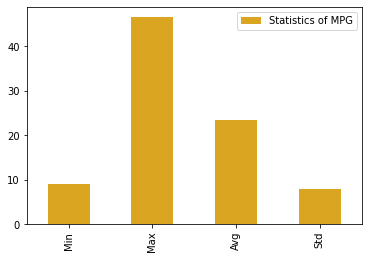

In [13]:
stat_mpg.plot(kind='bar', color='goldenrod')

In [14]:
print(mpg_avg-mpg_std, ' - ', mpg_avg, ' + ', mpg_avg+mpg_std)

15.640910880775138  -  23.445918367346938  +  31.250925853918737


**This is important information to take into consideration because Miles per Gallon is our target value. The average MPG of all the dataset's car is 23.45 with a standard deviation of 7.81. Practically, it can be said that it is normal that a car performs from 15.64 to 31.25 miles per gallon. Data points outside this range can be considered outliers.**

In [15]:
df['NAME'].value_counts()

amc matador             5
ford pinto              5
toyota corolla          5
amc gremlin             4
ford maverick           4
                       ..
mercedes-benz 240d      1
mercedes benz 300d      1
buick lesabre custom    1
mazda rx-4              1
nissan stanza xe        1
Name: NAME, Length: 301, dtype: int64

In [16]:
df = df.drop('NAME', axis = 1)

**There are 301 unique categoric values in the NAME column, which represents the 77% of the 392 records. Therefore, it is decided to skip it and not use it as a feature to train our neural network. Lets see the correlation of the other variables and the MPG column so we can select the best features!**

<AxesSubplot:>

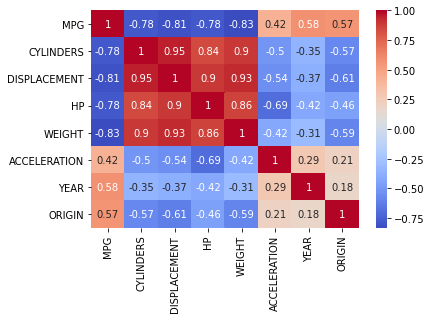

In [17]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

**We can perceive that each of the seven features: cylinders, displacement, HP, weight, acceleration, year, and origin, has a high level of correlation with MPG variable. As a result, we will use these seven features to train our model.** 

In [18]:
df = df.drop('MPG', axis = 1)

**Lets use Min Max Normalization to normalize all the seven features, transforming their values into a scale between 0 and 1.**

In [19]:
def normalize(dataset):
    data_normalized = ((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return data_normalized

In [20]:
features = normalize(df)
features

,CYLINDERS,DISPLACEMENT,HP,WEIGHT,ACCELERATION,YEAR,ORIGIN
0,1.0,0.617571,0.456522,0.536150,0.238095,0.0,0.0
1,1.0,0.728682,0.646739,0.589736,0.208333,0.0,0.0
2,1.0,0.645995,0.565217,0.516870,0.178571,0.0,0.0
3,1.0,0.609819,0.565217,0.516019,0.238095,0.0,0.0
4,1.0,0.604651,0.510870,0.520556,0.148810,0.0,0.0
...,...,...,...,...,...,...,...
393,0.2,0.186047,0.217391,0.333711,0.452381,1.0,0.0
394,0.2,0.074935,0.032609,0.146583,0.988095,1.0,0.5
395,0.2,0.173127,0.206522,0.193365,0.214286,1.0,0.0
396,0.2,0.134367,0.179348,0.286929,0.630952,1.0,0.0


## Pandas series to Numpy arrays

In [21]:
numpy_X = features[['CYLINDERS','DISPLACEMENT', 'HP', 'WEIGHT', 'ACCELERATION', 'YEAR', 'ORIGIN']].to_numpy()
numpy_X[:5]

array([[1.        , 0.61757106, 0.45652174, 0.5361497 , 0.23809524,
        0.        , 0.        ],
       [1.        , 0.72868217, 0.64673913, 0.58973632, 0.20833333,
        0.        , 0.        ],
       [1.        , 0.64599483, 0.56521739, 0.51686986, 0.17857143,
        0.        , 0.        ],
       [1.        , 0.60981912, 0.56521739, 0.51601928, 0.23809524,
        0.        , 0.        ],
       [1.        , 0.60465116, 0.51086957, 0.52055571, 0.14880952,
        0.        , 0.        ]])

In [22]:
numpy_y = y.to_numpy()
numpy_y[:5]

array([18., 15., 18., 16., 17.])

## Create a train (80%) and a test (20%) set 

In [23]:
train_X, test_X, train_y, test_y = train_test_split(numpy_X, numpy_y, test_size=0.20, random_state=0)

## Numpy arrays to Pytorch tensors train

In [24]:
# this is for the train set.
tensor_X = torch.from_numpy(train_X).float() 
tensor_y = torch.from_numpy(train_y).float() 
print(tensor_X.shape, tensor_y.shape)

torch.Size([313, 7]) torch.Size([313])


In [25]:
tensor_y = tensor_y.unsqueeze(1)
print(tensor_X.shape, tensor_y.shape)

torch.Size([313, 7]) torch.Size([313, 1])


In [26]:
torch_dataset = Data.TensorDataset(tensor_X, tensor_y)

## Define a dataloader to load it in batches

In [27]:
batch = 45 # we will have 8 iterations in each epoch. 313 data divided by 45 data 
           # per batch, is equal to 7 batches or iterations to complete one epoch.

In [28]:
loader = Data.DataLoader(
    dataset = torch_dataset,      # torch TensorDataset format
    batch_size = batch,           # mini batch size
    shuffle=True,                 # random shuffle for training
    num_workers=2,                # subprocesses for loading data
)

## Define a nn, optimizer, and loss function

In [29]:
model = nn.Sequential(nn.Linear(7, 10), # first layer
   nn.ReLU(),
   nn.Linear(10, 10), # second layer
   nn.ReLU(),
   nn.Linear(10, 10), # third layer
   nn.ReLU(),
   nn.Linear(10, 1)   # fourth layer
   )

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss()

## Train our Artificial Neural Network

In [31]:
loss_lst = []
for epoch in range(1, 101):
    batch = 1
    print("Epoch", epoch)
    for step, (batch_x, batch_y) in enumerate(loader): 
        var_X, var_y = Variable(batch_x), Variable(batch_y)
        prediction = model(var_X)
        rmse_loss = torch.sqrt(loss_function(prediction, var_y))

        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()
        
        loss_lst.append(float(rmse_loss))
        print("Batch: ", batch, ", loss: ", rmse_loss)
        batch += 1
    print("Result of the last epoch's batch: ", rmse_loss)
    print(' ')

Epoch 1
Batch:  1 , loss:  tensor(28.0374, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(25.8801, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(25.8305, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(23.7966, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(24.6145, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(22.9672, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(23.2274, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(23.2274, grad_fn=<SqrtBackward>)
 
Epoch 2
Batch:  1 , loss:  tensor(24.9091, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(23.9273, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(25.5893, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(25.0459, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(24.2673, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(25.8787, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(23.9831, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(23.9831, grad_fn=<SqrtBackward>)
 
Epoc

Batch:  1 , loss:  tensor(5.7000, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(5.9253, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(5.8118, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(5.3828, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(5.3020, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(5.0693, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(6.1126, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(6.1126, grad_fn=<SqrtBackward>)
 
Epoch 19
Batch:  1 , loss:  tensor(5.3291, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(4.9454, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(6.5648, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(5.8964, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(4.4621, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(5.4515, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(4.2824, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(4.2824, grad_fn=<SqrtBackward>)
 
Epoch 20
Batch:  1 , loss: 

Batch:  1 , loss:  tensor(3.3210, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(4.3557, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(3.9619, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(4.3312, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(5.0104, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(3.5668, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(4.0852, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(4.0852, grad_fn=<SqrtBackward>)
 
Epoch 36
Batch:  1 , loss:  tensor(3.9979, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(4.0126, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(4.3795, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(4.0195, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.7111, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(4.5588, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(3.9331, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(3.9331, grad_fn=<SqrtBackward>)
 
Epoch 37
Batch:  1 , loss: 

Batch:  1 , loss:  tensor(4.0603, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(2.8594, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(3.3408, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(2.7493, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.7615, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(3.5854, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(3.4179, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(3.4179, grad_fn=<SqrtBackward>)
 
Epoch 53
Batch:  1 , loss:  tensor(2.8550, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(3.4237, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(3.2873, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(3.5741, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.2322, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(4.0567, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(3.1322, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(3.1322, grad_fn=<SqrtBackward>)
 
Epoch 54
Batch:  1 , loss: 

Batch:  1 , loss:  tensor(2.4988, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(2.8446, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(2.9002, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(3.8146, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.1029, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(3.2537, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(2.4212, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(2.4212, grad_fn=<SqrtBackward>)
 
Epoch 70
Batch:  1 , loss:  tensor(3.3077, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(2.9667, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(2.6170, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(3.2371, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.1376, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(3.1297, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(2.5301, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(2.5301, grad_fn=<SqrtBackward>)
 
Epoch 71
Batch:  1 , loss: 

Batch:  1 , loss:  tensor(3.1515, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(3.3497, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(1.9591, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(2.5374, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(3.4668, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(3.3116, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(2.2590, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(2.2590, grad_fn=<SqrtBackward>)
 
Epoch 87
Batch:  1 , loss:  tensor(3.7095, grad_fn=<SqrtBackward>)
Batch:  2 , loss:  tensor(2.9425, grad_fn=<SqrtBackward>)
Batch:  3 , loss:  tensor(2.7410, grad_fn=<SqrtBackward>)
Batch:  4 , loss:  tensor(2.3002, grad_fn=<SqrtBackward>)
Batch:  5 , loss:  tensor(2.6013, grad_fn=<SqrtBackward>)
Batch:  6 , loss:  tensor(2.6965, grad_fn=<SqrtBackward>)
Batch:  7 , loss:  tensor(3.0717, grad_fn=<SqrtBackward>)
Result of the last epoch's batch:  tensor(3.0717, grad_fn=<SqrtBackward>)
 
Epoch 88
Batch:  1 , loss: 

## Plot the loss per epoch in training

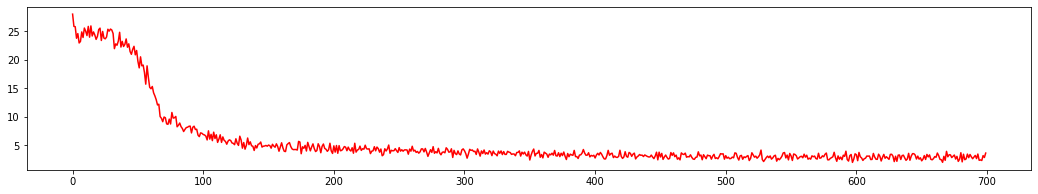

In [32]:
plt.figure(figsize=(18,3)) 
plt.plot(loss_lst, c='red')
plt.show()

## Test our Artificial Neural Network

**Convert Numpy arrays to Pytorch tensors for testing set.**

In [33]:
# this is for the test set.
tensor_X_test = torch.from_numpy(test_X).float() 
tensor_y_test = torch.from_numpy(test_y).float() 
print(tensor_X_test.shape, tensor_y_test.shape)

tensor_y_test = tensor_y_test.unsqueeze(1)
print(tensor_X_test.shape, tensor_y_test.shape)

torch.Size([79, 7]) torch.Size([79])
torch.Size([79, 7]) torch.Size([79, 1])


In [34]:
var_X_test = Variable(tensor_X_test)
var_y_test = Variable(tensor_y_test)

**Do predictions of the testing set and calculate the RMSE.**

In [35]:
predictions_test = model(var_X_test)

In [36]:
rmse_loss = torch.sqrt(loss_function(predictions_test, var_y_test))

In [37]:
rmse_loss

tensor(2.8001, grad_fn=<SqrtBackward>)

**The Root Mean Square Error of the testing set is 2.8, and since it is similar to the RMSE of the training set, we can conclude that there is not overfitting, perfect! An RMSE of 2.8 means that on average our model will do a prediction with a ± 2.8 error of miles per gallon. This is considered a satisfying result because 2.8 represents 12% out of the MPG average of our complete dataset and because 2.8 is lower than the MPG standard deviation of our whole dataset.**

## Plot the predictions against target values

In [38]:
y_pred = predictions_test.tolist()

In [39]:
y_real = var_y_test.tolist()

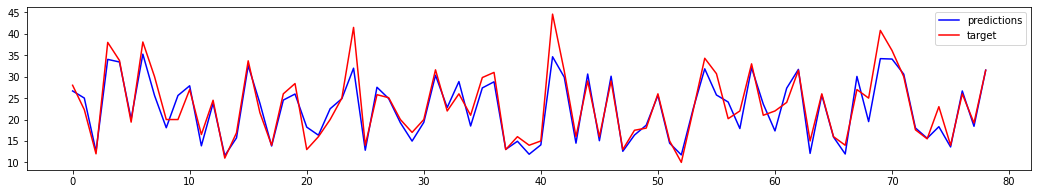

In [40]:
plt.figure(figsize=(18,3)) 
plt.plot(y_pred, c='blue', label="predictions")
plt.plot(y_real, c='red', label="target")
plt.legend(loc="upper right")
plt.show()

## Predict JUST one data with our model

In [41]:
data_x = var_X_test[0]
data_x

tensor([0.2000, 0.0568, 0.1576, 0.1452, 0.3869, 0.3333, 0.0000])

In [42]:
prediction = model(data_x)

In [43]:
print("Target value: ", var_y_test[0])
print("Prediction: ", prediction)

Target value:  tensor([28.])
Prediction:  tensor([26.6704], grad_fn=<AddBackward0>)


**When predicting only one data, the first one of the testing set, it can be seen that the target or real value is 28 MPG and that the prediction is 26.7. The prediction is really close and has an absolute error of 1.3 MPG or a percentage error of 4.6%.**